In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from kmedoids import fasterpam
from ripser import ripser
from persim import plot_diagrams
from tqdm import tqdm
from time import time

from yao_utils_otra import *
from atlas_pam import atlas_pam

 14%|█▍        | 14/100 [00:00<00:00, 139.93it/s]

Computing brute matrix...


100%|██████████| 100/100 [00:00<00:00, 141.21it/s]

Done


100%|██████████| 1000/1000 [00:01<00:00, 883.76it/s]


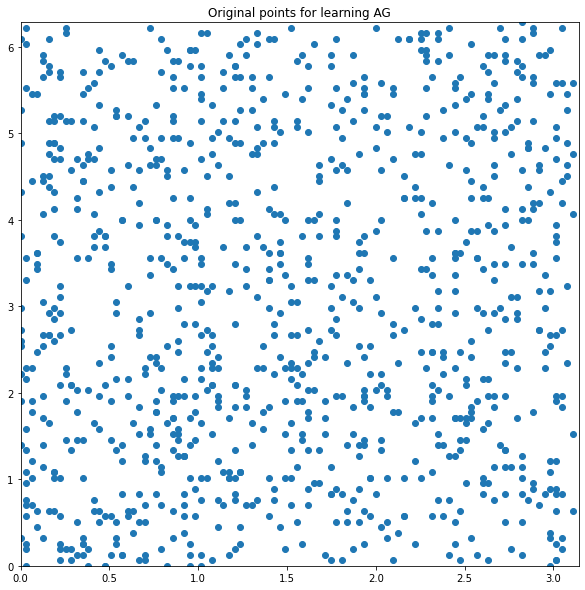

In [2]:
# Show original points for learning atlas graph
data_dir = "data/klein"
X = np.load(data_dir+"/klein_uniform_1000.npy")

theta_rec = []
phi_rec = []
for j in tqdm(range(X.shape[0])):
    x = X[j, :]
    theta, phi = find_closest_theta_phi_brute(x)
    theta_rec.append(theta)
    phi_rec.append(phi)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.scatter(theta_rec, phi_rec)
ax.set_xlim(0, np.pi)
ax.set_ylim(0, twopi)
ax.set_title("Original points for learning AG")

plt.show()

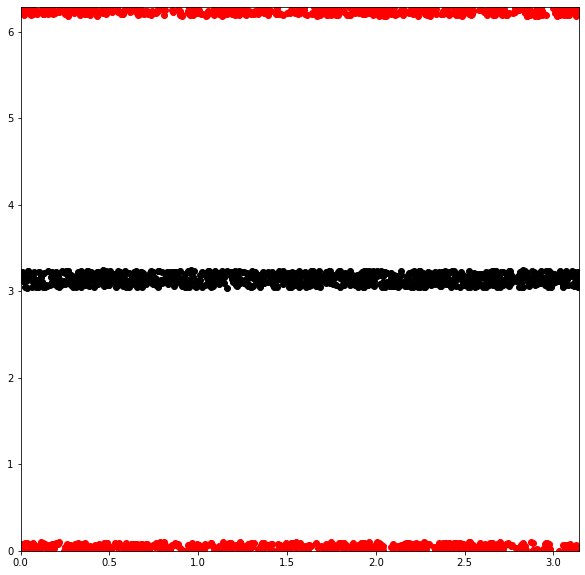

In [3]:
# Load in classification data
thetas_pos = np.load(data_dir+"/thetas_pos_razor_big.npy")
thetas_neg = np.load(data_dir+"/thetas_neg_razor_big.npy")
phis_pos = np.load(data_dir+"/phis_pos_razor_big.npy")
phis_neg = np.load(data_dir+"/phis_neg_razor_big.npy")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

ax.scatter(thetas_pos, phis_pos, color="r")
ax.scatter(thetas_neg, phis_neg, color="k")

ax.set_xlim(0, np.pi)
ax.set_ylim(0, 2*np.pi)

plt.show()

In [4]:
patches_pos = np.load(data_dir+"/patches_pos_razor_big.npy")
patches_neg = np.load(data_dir+"/patches_neg_razor_big.npy")
n_pos = patches_pos.shape[0]
n_neg = patches_neg.shape[0]

vecs_pos = []
vecs_neg = []
for j in range(patches_pos.shape[0]):
    vecs_pos.append(patches_pos[j, :, :].reshape(9))
    vecs_neg.append(patches_neg[j, :, :].reshape(9))
Vecs_pos = np.vstack(vecs_pos)
Vecs_neg = np.vstack(vecs_neg)

In [5]:
ac = atlas_pam(X, 2, 64)

  0%|          | 0/1000 [00:00<?, ?it/s]

Getting graph as sparse matrix...
Done
Getting graph from sparse matrix...
Done
Generating distance matrix...


100%|██████████| 1000/1000 [1:52:17<00:00,  6.74s/it] 


Done


In [6]:
def draw_total_in_polar():
    # Get points from each chart
    Xs = []
    for ind in tqdm(range(ac.n_charts)):
        X = ac.sample_uniformly_from_chart_by_ind(ind, grid_len=10)
        Xs.append(X)
    X = np.vstack(Xs)
    # Get polar representation
    theta_list = []
    phi_list = []
    for j in range(X.shape[0]):
        x = X[j, :]
        theta, phi = find_closest_theta_phi_brute(x)
        theta_list.append(theta)
        phi_list.append(phi)
    # Draw points in polar representation
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    ax.scatter(theta_list, phi_list, color="b")
    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, twopi)
    ax.set_title("All charts")
    # Show graphic
    plt.show()

100%|██████████| 64/64 [00:00<00:00, 190.77it/s]


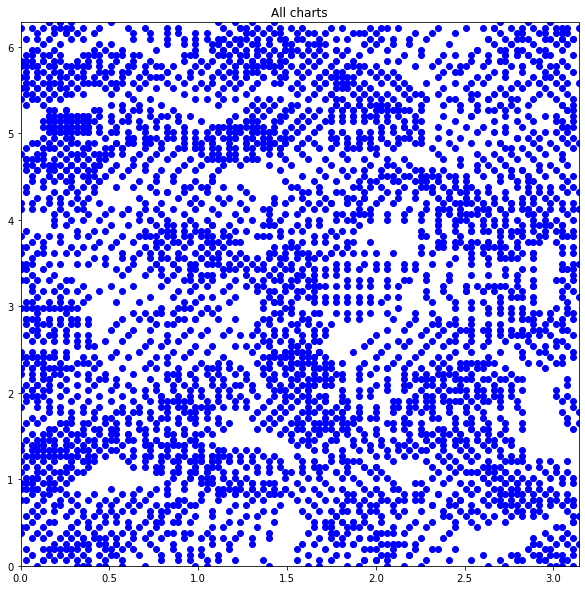

In [7]:
draw_total_in_polar()

In [8]:
n_pos = 100

xis_pos = []
inds_pos = []
xis_neg = []
inds_neg = []
for j in tqdm(range(n_pos)):
    # Positive
    x_pos = Vecs_pos[j, :]
    xi_pos, ind_pos = ac.ingest_ambient_point(x_pos)
    xis_pos.append(xi_pos)
    inds_pos.append(ind_pos)
    # Negative
    x_neg = Vecs_neg[j, :]
    xi_neg, ind_neg = ac.ingest_ambient_point(x_neg)
    xis_neg.append(xi_neg)
    inds_neg.append(ind_neg)

100%|██████████| 100/100 [00:00<00:00, 102.83it/s]


100%|██████████| 100/100 [00:00<00:00, 376.79it/s]


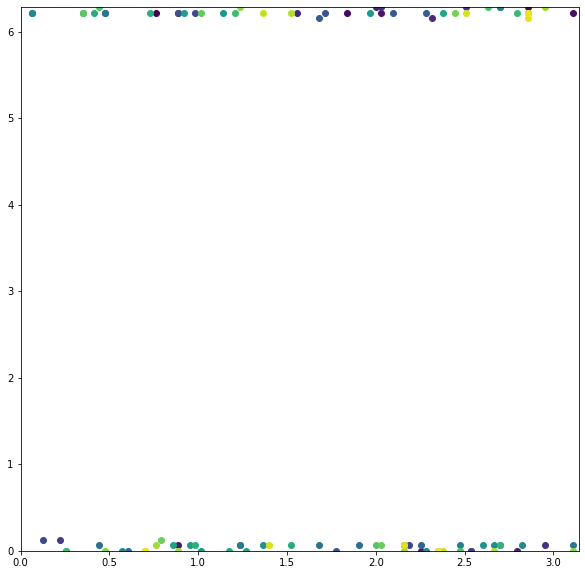

In [9]:
# Recreate positive band from atlas graph
theta_rec = []
phi_rec = []
for xi, ind in zip(xis_pos, inds_pos):
    x = ac.xi_ind_to_ambient(xi, ind)
    theta, phi = find_closest_theta_phi_brute(x)
    theta_rec.append(theta)
    phi_rec.append(phi)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

# Show classification data
rgb_map = colormaps["viridis"]

n_smol = 10

#for ind in tqdm(range(n_smol)):
for ind in tqdm(range(n_pos)):
    rgb = rgb_map(ind / n_pos)[:-1]
    ax.scatter([theta_rec[ind]], [phi_rec[ind]], color=rgb)

#ax.scatter(theta_rec, phi_rec, color="g")

ax.set_xlim(0, np.pi)
ax.set_ylim(0, 2*np.pi)

plt.show()

100%|██████████| 100/100 [00:00<00:00, 381.45it/s]


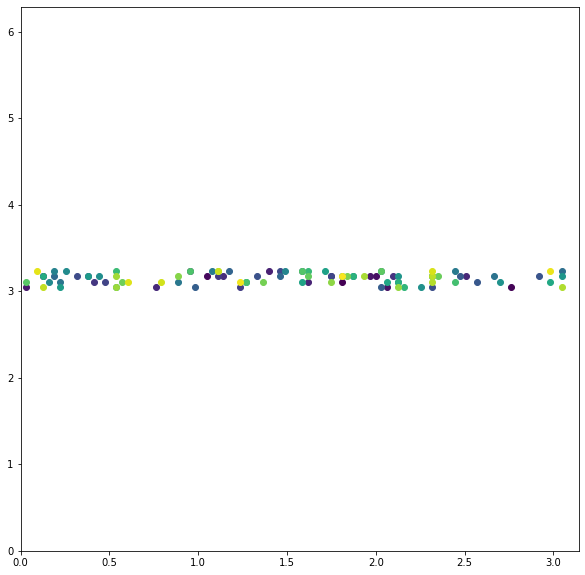

In [10]:
# Recreate negative band from atlas graph
theta_rec = []
phi_rec = []
for xi, ind in zip(xis_neg, inds_neg):
    x = ac.xi_ind_to_ambient(xi, ind)
    theta, phi = find_closest_theta_phi_brute(x)
    theta_rec.append(theta)
    phi_rec.append(phi)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

# Show classification data
rgb_map = colormaps["viridis"]

#for ind in tqdm(range(n_smol)):
for ind in tqdm(range(n_pos)):
    rgb = rgb_map(ind / n_pos)[:-1]
    ax.scatter([theta_rec[ind]], [phi_rec[ind]], color=rgb)

#ax.scatter(theta_rec, phi_rec, color="g")

ax.set_xlim(0, np.pi)
ax.set_ylim(0, 2*np.pi)

plt.show()

<h3>Save coordinate charts</h3>

In [12]:
ac.store_atlas("stored_charts/derp")